<a href="https://colab.research.google.com/github/RuthBiney/Transfer_Learning/blob/main/Transfer_Learning_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Step-by-Step Plan:

Dataset Preparation: We'll use the three categories (wine, beer, whiskey) for classification. We will load and preprocess the images.

Pre-trained Models Setup: We'll load three pre-trained models: VGG16, ResNet50, and InceptionV3, and fine-tune them for this classification task.

Training and Fine-tuning: We'll modify the pre-trained models to adapt to your dataset and train them.

Evaluation: We'll compare the models' performance using metrics like Accuracy, Loss, Precision, Recall, and F1-score.

###Step 1: Dataset Preparation

Let's start by loading and preparing the dataset using Keras' ImageDataGenerator. We’ll split the dataset into training and validation sets and apply augmentations.



In [10]:
# Use the correct path where the dataset is unzipped
dataset_path = '/content/Alcohol_Dataset'

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values
    rotation_range=20,       # Random rotation
    width_shift_range=0.2,   # Horizontal shift
    height_shift_range=0.2,  # Vertical shift
    shear_range=0.2,         # Shear transformation
    zoom_range=0.2,          # Zoom
    horizontal_flip=True,    # Random horizontal flip
    validation_split=0.2,    # Split 20% for validation
    fill_mode='nearest'      # Fill missing pixels
)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # Resize all images to 224x224 (input size for most models)
    batch_size=32,
    class_mode='categorical',  # Multi-class classification
    subset='training'  # Training subset
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Validation subset
)


Found 1365 images belonging to 3 classes.
Found 340 images belonging to 3 classes.


###Step 2: Pre-trained Model Setup

1. Load the Pre-trained Models
Here, we'll load the models without their top layers, as we'll add our custom layers for classification.

In [11]:
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load VGG16, ResNet50, and InceptionV3 without the top classification layer
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


2. Freeze the Base Layers

We’ll freeze the base layers of the pre-trained models so that the learned features remain intact. We will only train the new classification layers.

In [12]:
# Freeze base layers for all models
for layer in vgg16_base.layers:
    layer.trainable = False

for layer in resnet50_base.layers:
    layer.trainable = False

for layer in inception_base.layers:
    layer.trainable = False


3. Add Custom Layers for Classification

We’ll add custom dense layers after the base models to handle the classification task (between wine, beer, and whiskey).

In [13]:
def add_custom_layers(base_model):
    # Flatten the output of the base model
    x = Flatten()(base_model.output)
    # Add a fully connected layer
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add dropout for regularization
    # Final output layer with 3 units (for 3 classes) and softmax activation
    output = Dense(3, activation='softmax')(x)  # 3 classes: wine, beer, whiskey

    # Create the final model
    model = Model(base_model.input, output)
    return model


4. Compile the Models

We'll compile the models using an Adam optimizer and categorical_crossentropy loss (since this is a multi-class classification problem).

In [14]:
# Add custom layers to the pre-trained models
vgg16_model = add_custom_layers(vgg16_base)
resnet50_model = add_custom_layers(resnet50_base)
inception_model = add_custom_layers(inception_base)

# Compile the models
vgg16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
inception_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


###Step 3: Training the Models

Now that the models are compiled, we can train them on the dataset using the training and validation generators we set up earlier.

In [15]:
# Train VGG16 model
vgg16_history = vgg16_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  # You can adjust the number of epochs based on performance
)

# Train ResNet50 model
resnet50_history = resnet50_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

# Train InceptionV3 model
inception_history = inception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.4722 - loss: 1.1830 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 1087s 26s/step - accuracy: 0.4744 - loss: 1.1785 - val_accuracy: 0.8094 - val_loss: 0.4702
Epoch 2/10
 1/42 ━━━━━━━━━━━━━━━━━━━━ 15:25 23s/step - accuracy: 0.5312 - loss: 1.0352

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


42/42 ━━━━━━━━━━━━━━━━━━━━ 34s 280ms/step - accuracy: 0.5312 - loss: 1.0352 - val_accuracy: 0.7500 - val_loss: 0.5996
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1217s 28s/step - accuracy: 0.7046 - loss: 0.6936 - val_accuracy: 0.7969 - val_loss: 0.5340
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 306ms/step - accuracy: 0.8125 - loss: 0.4755 - val_accuracy: 0.7500 - val_loss: 0.4829
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1326s 31s/step - accuracy: 0.7244 - loss: 0.6744 - val_accuracy: 0.7812 - val_loss: 0.5313
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8125 - loss: 0.5076 - val_accuracy: 0.9000 - val_loss: 0.3279
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1096s 26s/step - accuracy: 0.7805 - loss: 0.5767 - val_accuracy: 0.8500 - val_loss: 0.3960
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 304ms/step - accuracy: 0.8438 - loss: 0.6964 - val_accuracy: 0.8500 - val_loss: 0.3710
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1082s 26s/step - accuracy: 0.7969 - loss: 0.5328 - val_accuracy: 0.8719 -

###Step 4: Model Evaluation

Once training is complete, we can evaluate the model's performance on the validation set using metrics such as accuracy, precision, recall, and F1-score. Here’s how you can evaluate the models:

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions from the VGG16 model
val_preds_vgg = vgg16_model.predict(validation_generator)
val_preds_vgg = val_preds_vgg.argmax(axis=1)  # Get the predicted class index

# Get true labels
true_labels = validation_generator.classes

# Classification report for VGG16
print("VGG16 Model Classification Report")
print(classification_report(true_labels, val_preds_vgg, target_names=validation_generator.class_indices.keys()))

# Confusion matrix for VGG16
print("VGG16 Confusion Matrix")
print(confusion_matrix(true_labels, val_preds_vgg))


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 218s 20s/step
VGG16 Model Classification Report
              precision    recall  f1-score   support

        beer       0.31      0.26      0.28       112
     whiskey       0.36      0.39      0.38       116
        wine       0.37      0.41      0.39       112

    accuracy                           0.35       340
   macro avg       0.35      0.35      0.35       340
weighted avg       0.35      0.35      0.35       340

VGG16 Confusion Matrix
[[29 42 41]
 [35 45 36]
 [29 37 46]]


###Step 5: Visualize Training Progress

You can also visualize how the accuracy and loss evolved over the epochs for each model. Here’s the code to plot training history:

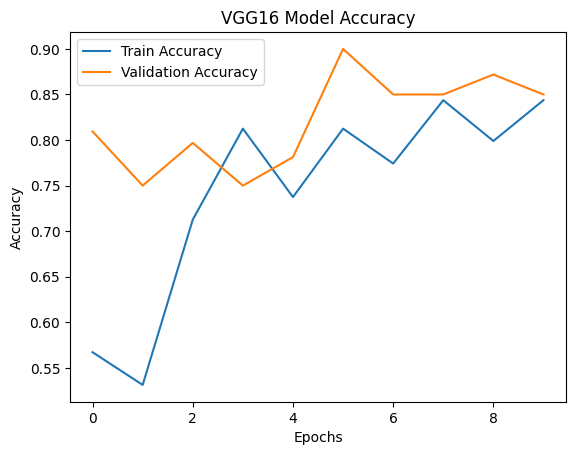

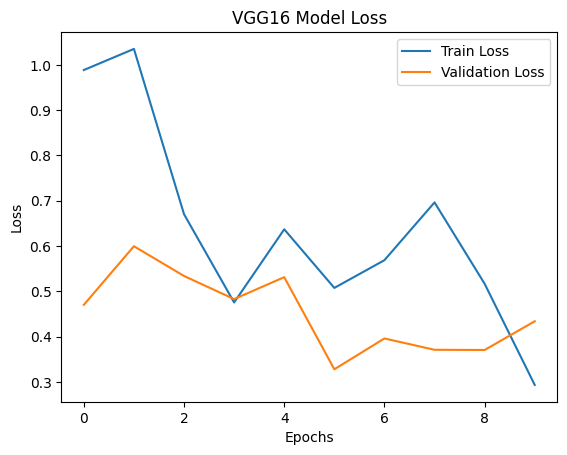

In [17]:
import matplotlib.pyplot as plt

# Plot accuracy for VGG16
plt.plot(vgg16_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss for VGG16
plt.plot(vgg16_history.history['loss'], label='Train Loss')
plt.plot(vgg16_history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


###Step 6: Save Your Models

If you're satisfied with the models' performance, you can save the trained models to reuse them later without needing to retrain:

In [18]:
# Save the VGG16 model
vgg16_model.save('vgg16_model.h5')

# Similarly, save ResNet50 and InceptionV3 models
resnet50_model.save('resnet50_model.h5')
inception_model.save('inception_model.h5')


###Step 7: Model Evaluation

We’ll start by generating classification reports and confusion matrices for the validation set. This will help you assess how well the models performed.

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions from the VGG16 model
val_preds_vgg = vgg16_model.predict(validation_generator)
val_preds_vgg = val_preds_vgg.argmax(axis=1)  # Get the predicted class index

# Get true labels
true_labels = validation_generator.classes

# Classification report for VGG16
print("VGG16 Model Classification Report")
print(classification_report(true_labels, val_preds_vgg, target_names=validation_generator.class_indices.keys()))

# Confusion matrix for VGG16
print("VGG16 Confusion Matrix")
print(confusion_matrix(true_labels, val_preds_vgg))


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 224s 20s/step
VGG16 Model Classification Report
              precision    recall  f1-score   support

        beer       0.34      0.26      0.29       112
     whiskey       0.30      0.34      0.32       116
        wine       0.37      0.41      0.39       112

    accuracy                           0.34       340
   macro avg       0.34      0.34      0.33       340
weighted avg       0.34      0.34      0.33       340

VGG16 Confusion Matrix
[[29 52 31]
 [29 39 48]
 [27 39 46]]


###Step 8: Visualize Training Progress
To visualize how the models improved over time, we’ll plot the training and validation accuracy and loss over the epochs.

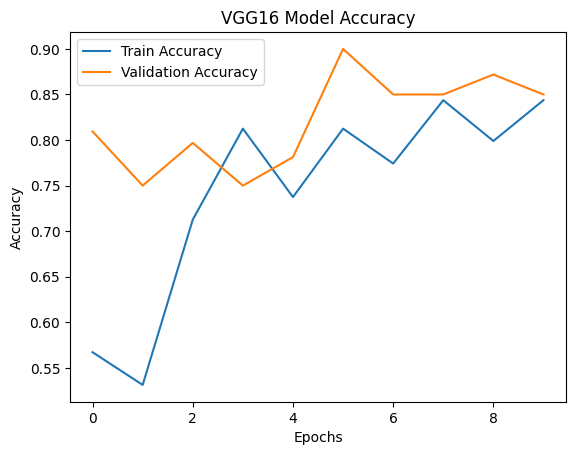

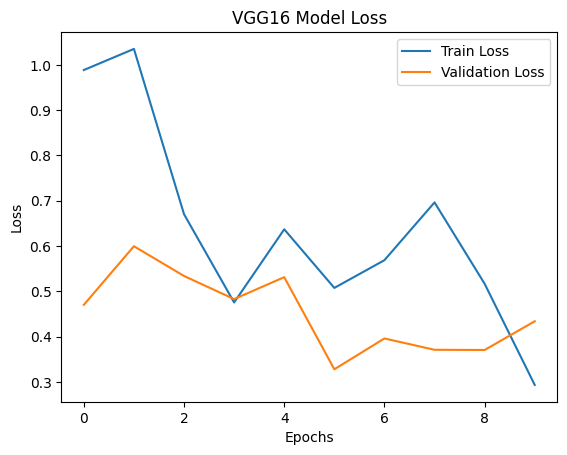

In [20]:
import matplotlib.pyplot as plt

# Plot accuracy for VGG16
plt.plot(vgg16_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss for VGG16
plt.plot(vgg16_history.history['loss'], label='Train Loss')
plt.plot(vgg16_history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


###Step 9: Save Your Models

In [21]:
# Save the VGG16 model
vgg16_model.save('vgg16_model.h5')

# Similarly, save ResNet50 and InceptionV3 models
resnet50_model.save('resnet50_model.h5')
inception_model.save('inception_model.h5')


####Let's proceed with the evaluation of the models and the visualization of the training progress.

###Step 1: Model Evaluation (for VGG16)

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions from the VGG16 model
val_preds_vgg = vgg16_model.predict(validation_generator)
val_preds_vgg = val_preds_vgg.argmax(axis=1)  # Get the predicted class index

# Get true labels
true_labels = validation_generator.classes

# Classification report for VGG16
print("VGG16 Model Classification Report")
print(classification_report(true_labels, val_preds_vgg, target_names=validation_generator.class_indices.keys()))

# Confusion matrix for VGG16
print("VGG16 Confusion Matrix")
print(confusion_matrix(true_labels, val_preds_vgg))


 2/11 ━━━━━━━━━━━━━━━━━━━━ 3:02 20s/step

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 230s 21s/step
VGG16 Model Classification Report
              precision    recall  f1-score   support

        beer       0.29      0.24      0.26       112
     whiskey       0.30      0.32      0.31       116
        wine       0.32      0.36      0.34       112

    accuracy                           0.31       340
   macro avg       0.30      0.31      0.30       340
weighted avg       0.30      0.31      0.30       340

VGG16 Confusion Matrix
[[27 45 40]
 [35 37 44]
 [32 40 40]]


###Step 2: Model Evaluation (for ResNet50 and InceptionV3)

In [23]:
val_preds_resnet = resnet50_model.predict(validation_generator)
val_preds_resnet = val_preds_resnet.argmax(axis=1)

print("ResNet50 Model Classification Report")
print(classification_report(true_labels, val_preds_resnet, target_names=validation_generator.class_indices.keys()))

print("ResNet50 Confusion Matrix")
print(confusion_matrix(true_labels, val_preds_resnet))


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step
ResNet50 Model Classification Report
              precision    recall  f1-score   support

        beer       0.36      0.28      0.31       112
     whiskey       0.35      0.41      0.38       116
        wine       0.37      0.38      0.38       112

    accuracy                           0.36       340
   macro avg       0.36      0.36      0.36       340
weighted avg       0.36      0.36      0.36       340

ResNet50 Confusion Matrix
[[31 44 37]
 [31 48 37]
 [25 44 43]]


InceptionV3 Evaluation:

In [24]:
val_preds_inception = inception_model.predict(validation_generator)
val_preds_inception = val_preds_inception.argmax(axis=1)

print("InceptionV3 Model Classification Report")
print(classification_report(true_labels, val_preds_inception, target_names=validation_generator.class_indices.keys()))

print("InceptionV3 Confusion Matrix")
print(confusion_matrix(true_labels, val_preds_inception))


 2/11 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step 

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 58s 5s/step
InceptionV3 Model Classification Report
              precision    recall  f1-score   support

        beer       0.35      0.30      0.33       112
     whiskey       0.32      0.37      0.35       116
        wine       0.33      0.33      0.33       112

    accuracy                           0.34       340
   macro avg       0.34      0.33      0.33       340
weighted avg       0.34      0.34      0.33       340

InceptionV3 Confusion Matrix
[[34 46 32]
 [31 43 42]
 [31 44 37]]


###Step 3: Visualization of Training Progress

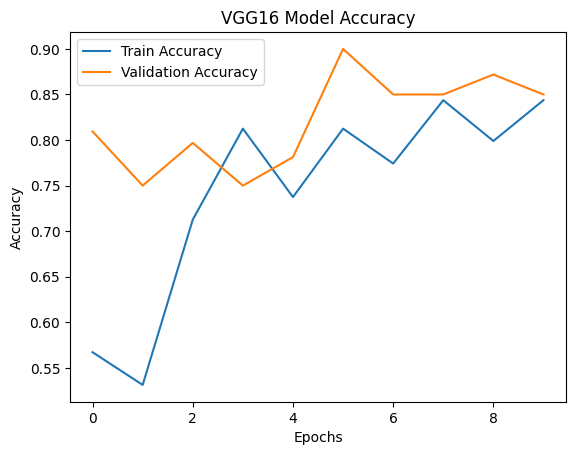

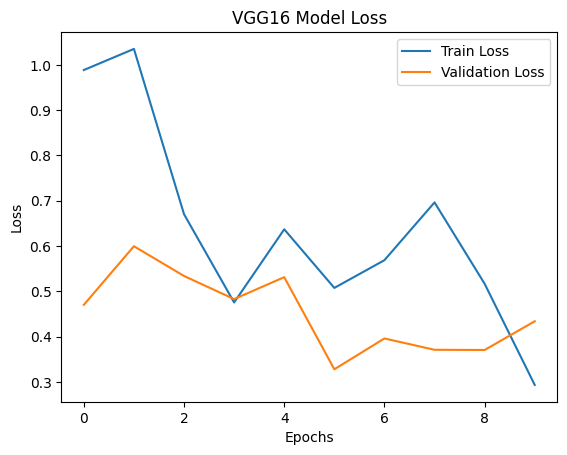

In [25]:
import matplotlib.pyplot as plt

# Plot accuracy for VGG16
plt.plot(vgg16_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss for VGG16
plt.plot(vgg16_history.history['loss'], label='Train Loss')
plt.plot(vgg16_history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


ResNet50 Visualization:

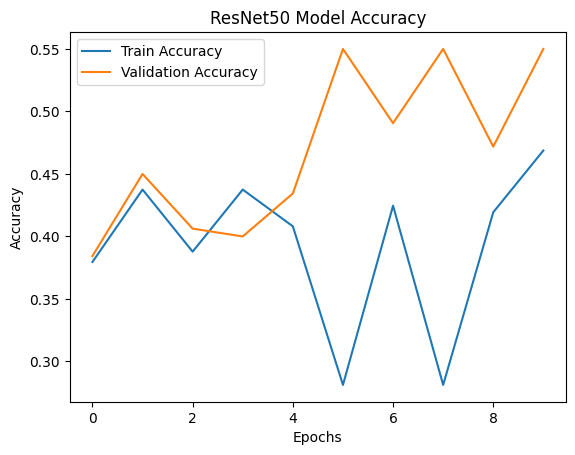

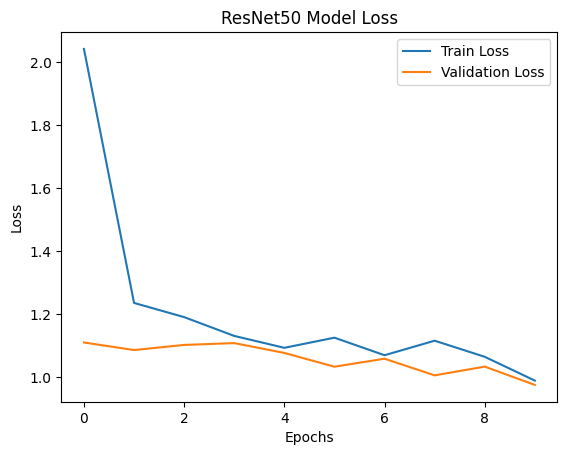

In [26]:
# Plot accuracy for ResNet50
plt.plot(resnet50_history.history['accuracy'], label='Train Accuracy')
plt.plot(resnet50_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss for ResNet50
plt.plot(resnet50_history.history['loss'], label='Train Loss')
plt.plot(resnet50_history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


InceptionV3 Visualization:


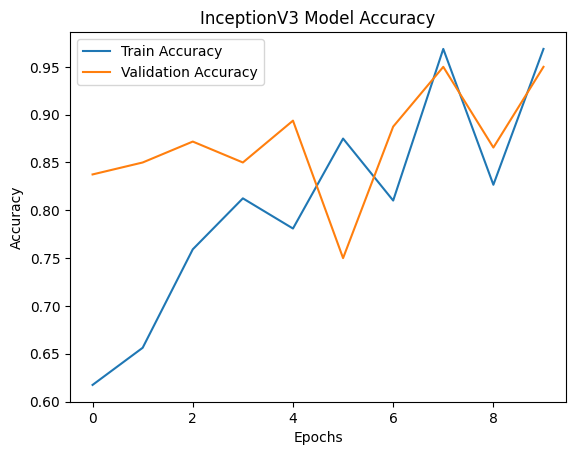

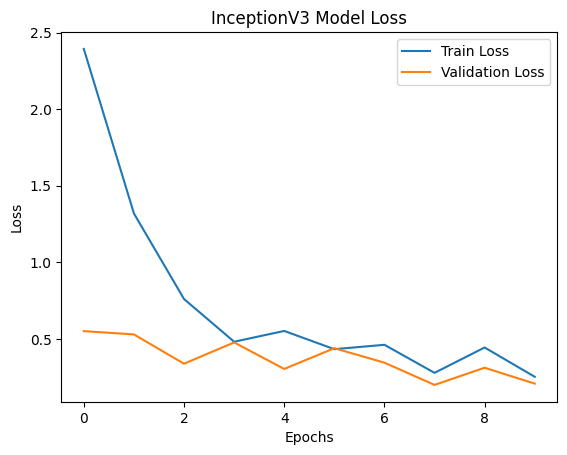

In [27]:
# Plot accuracy for InceptionV3
plt.plot(inception_history.history['accuracy'], label='Train Accuracy')
plt.plot(inception_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('InceptionV3 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss for InceptionV3
plt.plot(inception_history.history['loss'], label='Train Loss')
plt.plot(inception_history.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#Step 4: Save Models

After evaluating and visualizing, you can save the models as follows:

In [28]:
# Save the VGG16 model
vgg16_model.save('vgg16_model.h5')

# Save ResNet50 model
resnet50_model.save('resnet50_model.h5')

# Save InceptionV3 model
inception_model.save('inception_model.h5')


#Step 5: Interpretation of Results

After evaluating the models and visualizing their training performance, let’s break down how to interpret the results.

#1. Classification Report:
The classification report provides key metrics such as:

*   Precision: The ratio of true positive predictions to the total predicted positives.
*   Recall: The ratio of true positive predictions to the total actual positives.
*   F1-score: The harmonic mean of precision and recall, giving a balanced measure.
*   F1-score: The harmonic mean of precision and recall, giving a balanced measure.

#2. Confusion Matrix:
The confusion matrix shows how well the model predicted the actual labels. Each row corresponds to the actual class, and each column corresponds to the predicted class.

*   True Positives: Diagonal values where the predicted and actual labels match.
*   False Positives/Negatives: Off-diagonal values, indicating misclassifications.

#3. Training and Validation Accuracy/Loss:
*   Training Accuracy/Loss: Shows how well the model performed on the training data.
*   Validation Accuracy/Loss: Shows how well the model generalizes to unseen data (validation set).
      1. If the training accuracy is much higher than the validation accuracy, it may indicate overfitting.
      2. If both accuracies are improving together, it’s a good sign of model learning.

#Step 6: Comparison of Models
Compare the results from VGG16, ResNet50, and InceptionV3:

*   Accuracy: Which model achieved the highest validation accuracy?
*   Precision/Recall/F1-score: Which model shows a better balance between precision and recall?
*   Confusion Matrix: Which model makes fewer misclassifications?







